In [23]:
import numpy as np
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

#load pokemon images from folder/directory
def load_images(path):
    filenames = listdir(path)
    img_list = list()
    
    for name in filenames:
        poke_img = load_img(path + name)
        poke_img = img_to_array(poke_img)
        img_list.append(poke_img)
        
    return [asarray(img_list)]

In [25]:
#folder containing images
path = 'pokemon/'
#array of images
[poke_list] = load_images(path)
#real labels '1'
poke_labels = np.ones((poke_list.shape[0], 1))

print(poke_list.shape, poke_labels.shape)

(819, 256, 256, 3) (819, 1)


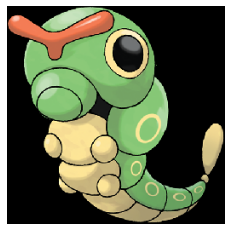

In [26]:
plt.axis("off")
plt.imshow(poke_list[1].astype('uint8'))

In [35]:
#make fake/noisy images

def make_noise(samples):
    noise_list = list()
    
    for i in range(samples):
        noise = np.random.normal(0, 1, size=64)
        noise_list.append(noise)
    
    return [asarray(noise_list)]

In [36]:
[noise_samples] = make_noise(100)
print(noise_samples.shape)

(100, 64)


In [37]:
# plt.axis("off")
# plt.imshow(noise_samples[1].astype('uint8'))

In [38]:
#real image batch generator
def generate_batch_real(samples):
    
    np.random.shuffle(poke_list)
    batch = poke_list[0:samples, :, :, :]
    
    return [asarray(batch), asarray(poke_labels[0:samples])]

In [39]:
[real_batch, real_labels] = generate_batch_real(100)
print(real_batch.shape, real_labels.shape)

(100, 256, 256, 3) (100, 1)


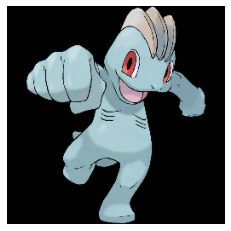

In [40]:
plt.axis("off")
plt.imshow(real_batch[1].astype('uint8'))

In [41]:
#fake/noise image batch generator
def generate_batch_fake(samples):
    
    [x] = make_noise(samples)
    y = np.zeros((samples, 1))
    
    return [asarray(x), asarray(y)]

In [42]:
[fake_batch, fake_labels] = generate_batch_fake(100)
print(fake_batch.shape, fake_labels.shape)

(100, 64) (100, 1)


In [43]:
#discriminator
def discriminator():
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(64, (4, 4), strides=(2,2), padding='same', input_shape = (256, 256, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (4, 4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, (4, 4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(512, (4, 4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(512, (4, 4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    # opt = layers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [44]:
model_discriminator = discriminator()
model_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 256)       524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 256)      

In [45]:
def train_discriminator(model, epochs, batch_size):
    
    for i in range(epochs):
        
        [real_batch, real_labels] = generate_batch_real(batch_size)
        model.train_on_batch(real_batch, real_labels)
        
        [fake_batch, fake_labels] = generate_batch_fake(batch_size)
        model.train_on_batch(fake_batch, fake_labels)
        
        loss_real, acc_real = model.evaluate(real_batch, real_labels, verbose=0)
        loss_fake, acc_fake = model.evaluate(fake_batch, fake_labels, verbose=0)
        
        if(i%5==0):
            print(i, acc_real, acc_fake)

In [1]:
# train_discriminator(model_discriminator, 100, 50)

In [72]:
from keras.models import Input
from keras.models import Model

def generator():
    
    noise_input = Input(shape=(64,))
    
    x = layers.Dense(128*128*8)(noise_input)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((128, 128, 8))(x)
    
    x = layers.Conv2D(16, (5,5), strides=1, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(32, (5,5), strides=1, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
#     x = layers.Conv2D(64, (5,5), strides=1, padding='same')(x)
#     x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(64, (4,4), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, (5,5), strides=1, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, (5,5), strides=1, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(3, (5,5), strides=1, activation='tanh', padding='same')(x)
    
    model = Model(noise_input, x)
    
    return model

In [73]:
model_generator = generator()
model_generator.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 131072)            8519680   
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 131072)            0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 128, 128, 16)      3216      
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 128, 128, 32)      128

In [74]:
# from keras import layers
# # import numpy as np
# latent_dim = 32
# channels = 3

# generator_input = keras.Input(shape=(latent_dim,))
# x = layers.Dense(128 * 16 * 16)(generator_input)
# x = layers.LeakyReLU()(x)
# x = layers.Reshape((16, 16, 128))(x)

# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
# x = layers.LeakyReLU()(x)

# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
# generator = keras.models.Model(generator_input, x)
# generator.summary()

In [51]:
print(fake_batch[1])

[ 0.06436088 -0.20959281  0.89346275 -1.380074   -0.83129734 -0.49476512
 -1.45340666 -2.0205361  -1.79483849 -0.14141688 -1.19094922 -0.72708656
 -0.48723394  0.61481335  0.37743733  1.96243334  0.9786486  -0.21519686
 -0.04609877  0.97235036 -2.17068982  0.41157096  0.33574984  0.07509926
 -0.27391175 -1.85582952  1.2126181   0.95988778 -1.80073716  0.55167926
 -0.97364944 -0.94275866 -0.69714675 -1.02050092 -0.36676288 -1.48893722
 -0.37578726  0.26757453 -0.23734058 -0.91691338 -1.57632679 -2.17786772
  2.24390482  0.1757141  -1.30223834  0.12058152  1.57957646  1.44303494
 -0.63397444 -0.48801915 -0.32529442  0.94847813  0.48532893  0.93976681
 -1.02791017  0.31024836  1.81840535  0.91514947 -1.35126839 -0.93872595
 -0.96455693 -0.72590128 -1.00791662  1.58957637]


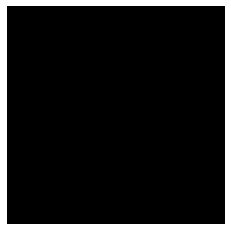

In [53]:
img = model_generator.predict(fake_batch[:1,:])
img = img.reshape((256,256,3))
plt.axis("off")
plt.imshow(img.astype('uint8'))

In [75]:
#GAN model
def gan(g_model, d_model):

  d_model.trainable = False
  noise_input = Input(shape=(64,))

  g_out = g_model(noise_input)
  d_out = d_model(g_out)

  model = Model(noise_input, d_out)

  model.compile(optimizer='adam', loss='binary_crossentropy')

  return model

In [76]:
model_gan = gan(model_generator, model_discriminator)
model_gan.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 64)                0         
_________________________________________________________________
model_17 (Model)             (None, 256, 256, 3)       9192819   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 6989761   
Total params: 16,182,580
Trainable params: 9,192,819
Non-trainable params: 6,989,761
_________________________________________________________________


In [77]:
def gan_performance(epoch, g_model, d_model, batch_size):
    
    #real images
    [real_batch, real_labels] = generate_batch_real(batch_size)
    #noise image
    [fake_batch, fake_labels] = generate_batch_fake(batch_size)

    fake_batch = g_model.predict(fake_batch)
    
    #discirminator accuracy
    loss_real, acc_real = d_model.evaluate(real_batch, real_labels, verbose=0)
    loss_fake, acc_fake = d_model.evaluate(fake_batch, fake_labels, verbose=0)
    
    print(epoch, acc_real, acc_fake)
    
    #generated image
    plt.axis("off")
    plt.imshow(fake_batch[1].astype('uint8'))
    plt.show()

In [78]:
def train_gan(gan_model, g_model, d_model, epochs, batch_size):

  for i in range(epochs):
    #real images
    [real_batch, real_labels] = generate_batch_real(batch_size)
    #noise image
    [fake_batch, fake_labels] = generate_batch_fake(batch_size)

    #generate images to be fed to discriminator
    fake_batch = g_model.predict(fake_batch)

    d_model.train_on_batch(real_batch, real_labels)
    d_model.train_on_batch(fake_batch, fake_labels)

    #fresh input for gan
    [fake_batch, fake_labels] = generate_batch_fake(batch_size)
    #renaming labels for adversarial loss
    fake_labels = np.ones((batch_size, 1))

    gan_model.train_on_batch(fake_batch, fake_labels)

    if((i+1)%5==0):
      gan_performance(i, g_model, d_model, batch_size)

In [79]:
train_gan(model_gan, model_generator, model_discriminator, 100, 50)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv2d_70/convolution (defined at D:\anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_4789]

Function call stack:
keras_scratch_graph
